In [1]:
library(dplyr)
library(ggplot2)
library(gridExtra)
library(rpart)
library(rpart.plot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Supervised model

In [2]:
initial_adult <- read.csv("./datasets/adult.csv")

In [3]:
adult <- select(initial_adult, -c(x, educational.num))
head(adult)

,age,workclass,education,marital.status,race,gender,hours.per.week,income
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,25,Private,11th,Never-married,Black,Male,40,<=50K
2,38,Private,HS-grad,Married-civ-spouse,White,Male,50,<=50K
3,28,Local-gov,Assoc-acdm,Married-civ-spouse,White,Male,40,>50K
4,44,Private,Some-college,Married-civ-spouse,Black,Male,40,>50K
5,18,?,Some-college,Never-married,White,Female,30,<=50K
6,34,Private,10th,Never-married,White,Male,30,<=50K


In [4]:
summary(adult)

      age         workclass          education         marital.status    
 Min.   :17.00   Length:48842       Length:48842       Length:48842      
 1st Qu.:28.00   Class :character   Class :character   Class :character  
 Median :37.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :38.64                                                           
 3rd Qu.:48.00                                                           
 Max.   :90.00                                                           
     race              gender          hours.per.week     income         
 Length:48842       Length:48842       Min.   : 1.00   Length:48842      
 Class :character   Class :character   1st Qu.:40.00   Class :character  
 Mode  :character   Mode  :character   Median :40.00   Mode  :character  
                                       Mean   :40.42                     
                                       3rd Qu.:45.00                     
                                      

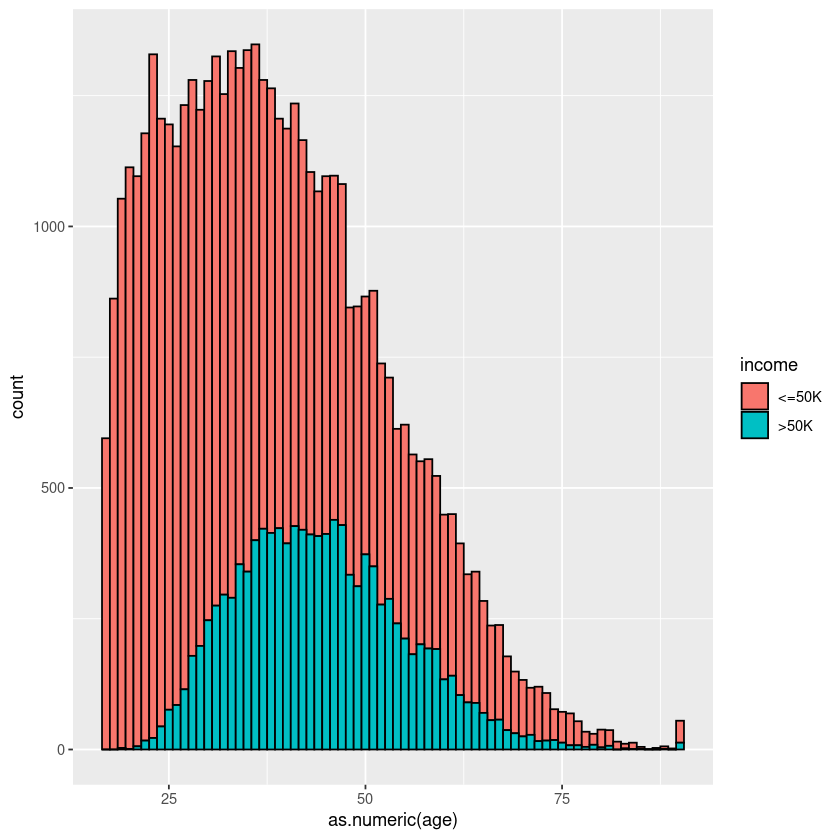

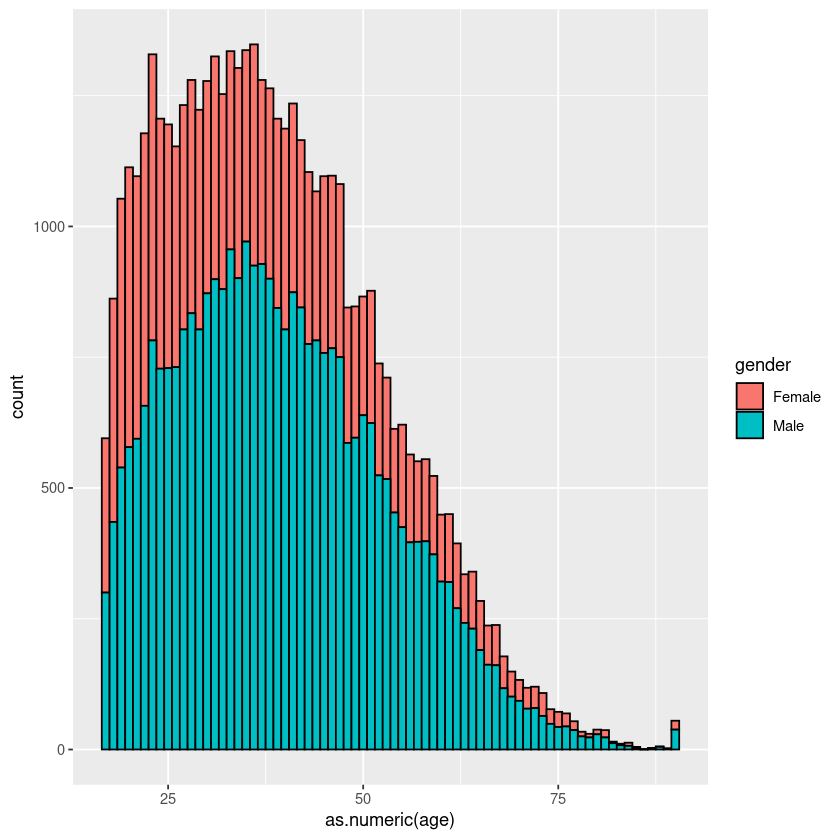

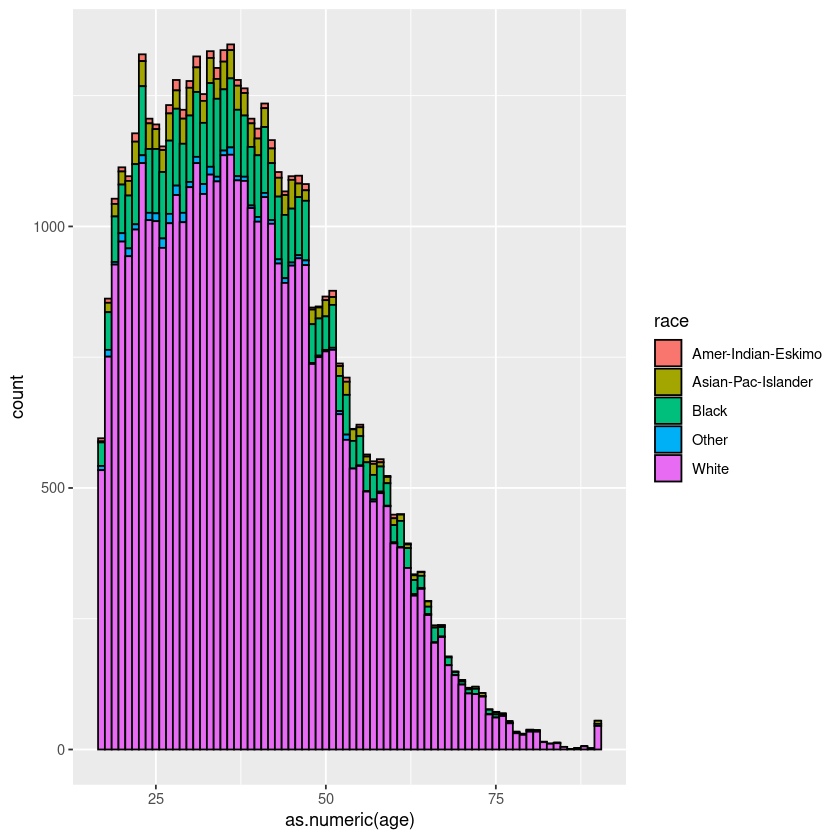

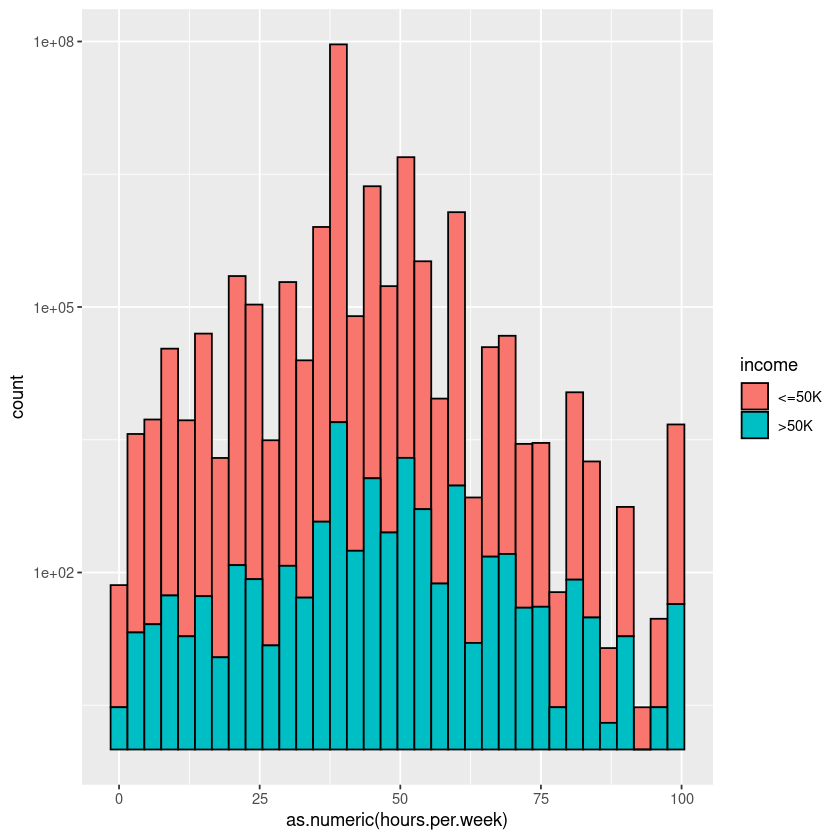

In [5]:
ggplot(adult) + aes(x=as.numeric(age), group=income, fill=income) + 
  geom_histogram(binwidth=1, color="black")
ggplot(adult) + aes(x=as.numeric(age), group=gender, fill=gender) + 
  geom_histogram(binwidth=1, color='black')
ggplot(adult) + aes(x=as.numeric(age), group=race, fill=race) + 
  geom_histogram(binwidth=1, color='black')
ggplot(adult) + aes(x=as.numeric(hours.per.week), group=income, fill=income) + 
  geom_histogram(binwidth=3, color='black') +
  scale_y_log10()

In [6]:
sum(is.na(adult))

[1] 0

There is no NA, but we want to investigate whether there are missing values categorized as some other way.

In [7]:
for (col in colnames(adult)){
    print(c(unique(adult[col])))
}

$age
 [1] 25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54 32
[26] 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79 73 53
[51] 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88 87 86

$workclass
[1] "Private"          "Local-gov"        "?"                "Self-emp-not-inc"
[5] "Federal-gov"      "State-gov"        "Self-emp-inc"     "Without-pay"     
[9] "Never-worked"    

$education
 [1] "11th"         "HS-grad"      "Assoc-acdm"   "Some-college" "10th"        
 [6] "Prof-school"  "7th-8th"      "Bachelors"    "Masters"      "Doctorate"   
[11] "5th-6th"      "Assoc-voc"    "9th"          "12th"         "1st-4th"     
[16] "Preschool"   

$marital.status
[1] "Never-married"         "Married-civ-spouse"    "Widowed"              
[4] "Divorced"              "Separated"             "Married-spouse-absent"
[7] "Married-AF-spouse"    

$race
[1] "Black"              "White"              "Asian-Pac-Islander"
[4] "Other"         

There are some `?` values in the `workclass` column and `Other` in the `race` column.

In [8]:
sum(adult$workclass == "?") # number of `?`
sum(adult$race == "Other") # number of `Other`

[1] 2799

[1] 406

Drop "?" and "other" observations

In [9]:
adult <- adult[!adult$workclass == "?",]
adult <- adult[!adult$race == "Other",]

Now label encode categorical values before feeding

In [10]:
for (col in c("workclass", "education", "marital.status", "race", "gender", "income")){
    adult[[col]] <- as.integer(factor(adult[[col]], labels=1:length(unique(adult[[col]]))))-1
}

In [11]:
create_train_test <- function(data, size=0.8, train=TRUE, seed=TRUE){
    if (seed) {
        set.seed(42)
    }
    smp_size <- floor(size * nrow(data))
    train_ind <- sample(seq_len(nrow(data)), size = smp_size)
    
    if (train) {
        return (data[train_ind, ])
    } else {
        return (data[-train_ind, ])
    }
}
data_train <- create_train_test(adult, size=0.8, train=TRUE)
data_test <- create_train_test(adult, size=0.8, train=FALSE)
# X_train <- select(data_train, -income)
# y_train <- select(data_train, income)
# X_test <- select(data_test, -income)
# y_test <- select(data_test, income)

In [12]:
dim(data_train)
dim(data_test)

[1] 36534     8

[1] 9134    8

In [13]:
prop.table(table(data_train$income))
prop.table(table(data_test$income))


        0         1 
0.7499589 0.2500411 


        0         1 
0.7547624 0.2452376 

### Plot decision tree

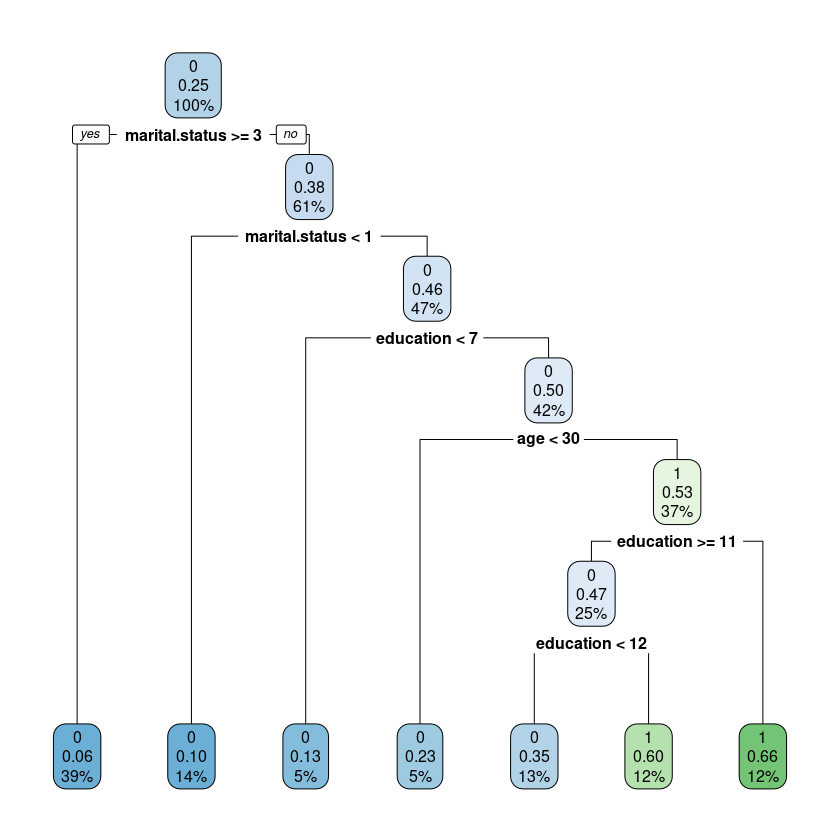

In [14]:
fit <- rpart(income~., data_train, method="class")
rpart.plot(fit, extra=106)

### Display confusion

In [15]:
pred <- predict(fit, data_test, type="class")
conf_mat <- table(pred, data_test$income)
print(conf_mat)

    
pred    0    1
   0 6085  887
   1  809 1353


### Deduce model accuracy

In [16]:
accuracy <- sum(diag(conf_mat)) / sum(conf_mat)
print(paste("accuracy:", accuracy))

[1] "accuracy: 0.814320122618787"


### Display model parameters

In [17]:
rpart.control()

$minsplit
[1] 20

$minbucket
[1] 7

$cp
[1] 0.01

$maxcompete
[1] 4

$maxsurrogate
[1] 5

$usesurrogate
[1] 2

$surrogatestyle
[1] 0

$maxdepth
[1] 30

$xval
[1] 10

In [18]:
control <- rpart.control()
fit <- rpart(income~., data_train, method="class", control=control)
pred <- predict(fit, data_test, type="class")
conf_mat <- table(pred, data_test$income)
print(conf_mat)
accuracy <- sum(diag(conf_mat)) / sum(conf_mat)
print(paste("accuracy:", accuracy))

    
pred    0    1
   0 6085  887
   1  809 1353
[1] "accuracy: 0.814320122618787"


# Unsupervised model

In [19]:
library(cluster)
library(factoextra)
library(magrittr)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [76]:
initial_cars <- mtcars
cars <- data.frame(initial_cars)
head(initial_cars)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1


In [67]:
sum(is.na(cars_data)) # no NA

[1] 0

In [77]:
for (col in colnames(cars)){
    print(c(unique(cars[col])))
}

$mpg
 [1] 21.0 22.8 21.4 18.7 18.1 14.3 24.4 19.2 17.8 16.4 17.3 15.2 10.4 14.7 32.4
[16] 30.4 33.9 21.5 15.5 13.3 27.3 26.0 15.8 19.7 15.0

$cyl
[1] 6 4 8

$disp
 [1] 160.0 108.0 258.0 360.0 225.0 146.7 140.8 167.6 275.8 472.0 460.0 440.0
[13]  78.7  75.7  71.1 120.1 318.0 304.0 350.0 400.0  79.0 120.3  95.1 351.0
[25] 145.0 301.0 121.0

$hp
 [1] 110  93 175 105 245  62  95 123 180 205 215 230  66  52  65  97 150  91 113
[20] 264 335 109

$drat
 [1] 3.90 3.85 3.08 3.15 2.76 3.21 3.69 3.92 3.07 2.93 3.00 3.23 4.08 4.93 4.22
[16] 3.70 3.73 4.43 3.77 3.62 3.54 4.11

$wt
 [1] 2.620 2.875 2.320 3.215 3.440 3.460 3.570 3.190 3.150 4.070 3.730 3.780
[13] 5.250 5.424 5.345 2.200 1.615 1.835 2.465 3.520 3.435 3.840 3.845 1.935
[25] 2.140 1.513 3.170 2.770 2.780

$qsec
 [1] 16.46 17.02 18.61 19.44 20.22 15.84 20.00 22.90 18.30 18.90 17.40 17.60
[13] 18.00 17.98 17.82 17.42 19.47 18.52 19.90 20.01 16.87 17.30 15.41 17.05
[25] 16.70 16.90 14.50 15.50 14.60 18.60

$vs
[1] 0 1

$am
[1] 1 0

$gear
[

In [81]:
cars <- data.frame(scale(cars))
head(cars)
cars <- select(cars, -c(mpg))

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,0.1508848,-0.1049878,-0.57061982,-0.5350928,0.5675137,-0.610399567,-0.7771651,-0.8680278,1.1899014,0.4235542,0.7352031
Mazda RX4 Wag,0.1508848,-0.1049878,-0.57061982,-0.5350928,0.5675137,-0.349785269,-0.4637808,-0.8680278,1.1899014,0.4235542,0.7352031
Datsun 710,0.4495434,-1.2248578,-0.99018209,-0.7830405,0.4739996,-0.917004624,0.4260068,1.1160357,1.1899014,0.4235542,-1.1221521
Hornet 4 Drive,0.2172534,-0.1049878,0.22009369,-0.5350928,-0.9661175,-0.002299538,0.8904872,1.1160357,-0.8141431,-0.9318192,-1.1221521
Hornet Sportabout,-0.2307345,1.0148821,1.04308123,0.4129422,-0.8351978,0.227654255,-0.4637808,-0.8680278,-0.8141431,-0.9318192,-0.5030337
Valiant,-0.3302874,-0.1049878,-0.04616698,-0.6080186,-1.5646078,0.248094592,1.3269868,1.1160357,-0.8141431,-0.9318192,-1.1221521


In [82]:
km.res <- kmeans(cars, 3, nstart=25)

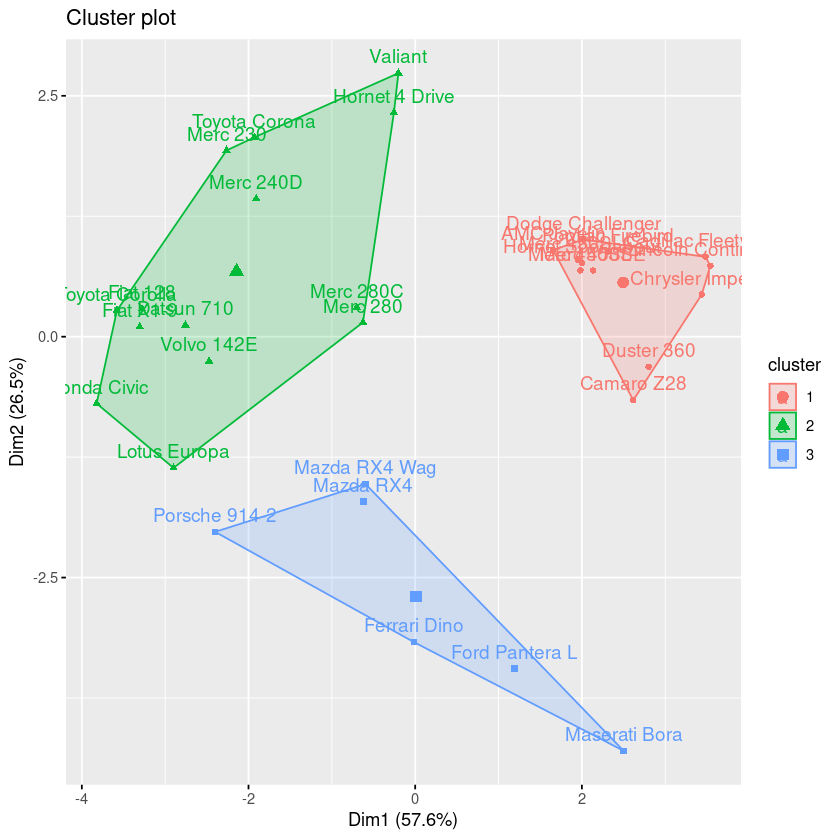

In [83]:
fviz_cluster(km.res, data=cars, ellipse.type="convex")

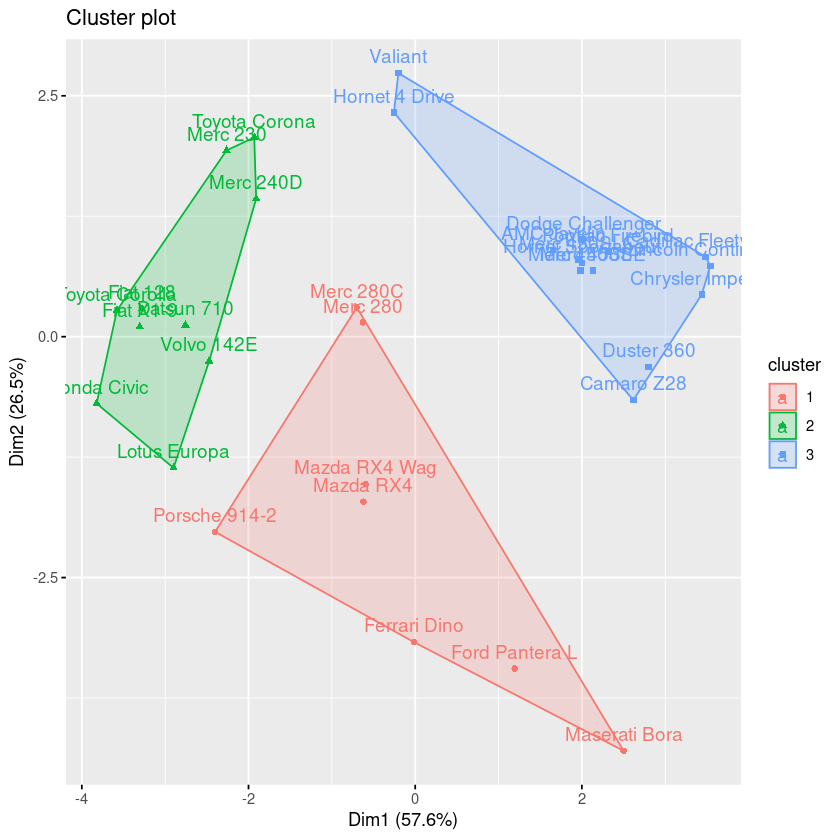

In [84]:
pam.res <- pam(cars, 3)
fviz_cluster(pam.res) #almost similar to kmeans results

We see that for the most part, K-means and PAM classify in the same way. Only some samples between the center and the upper-right classes change class when modifying the method.